<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigureS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pingouin > /dev/null 2>&1
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pingouin as pg
import os
import warnings
from scipy.stats import ttest_rel

warnings.filterwarnings("ignore")

def add_sig_line(ax, x1, x2, y, p_val, h=1):
    if p_val < 0.0001:
        stars = '****'
    elif p_val < 0.001:
        stars = '***'
    elif p_val < 0.01:
        stars = '**'
    elif p_val < 0.05:
        stars = '*'
    else:
        return
    ax.text((x1 + x2) / 2, y, stars, ha='center', va='bottom', fontsize=13)

Paired t-test: t = 1.796, p = 0.10001


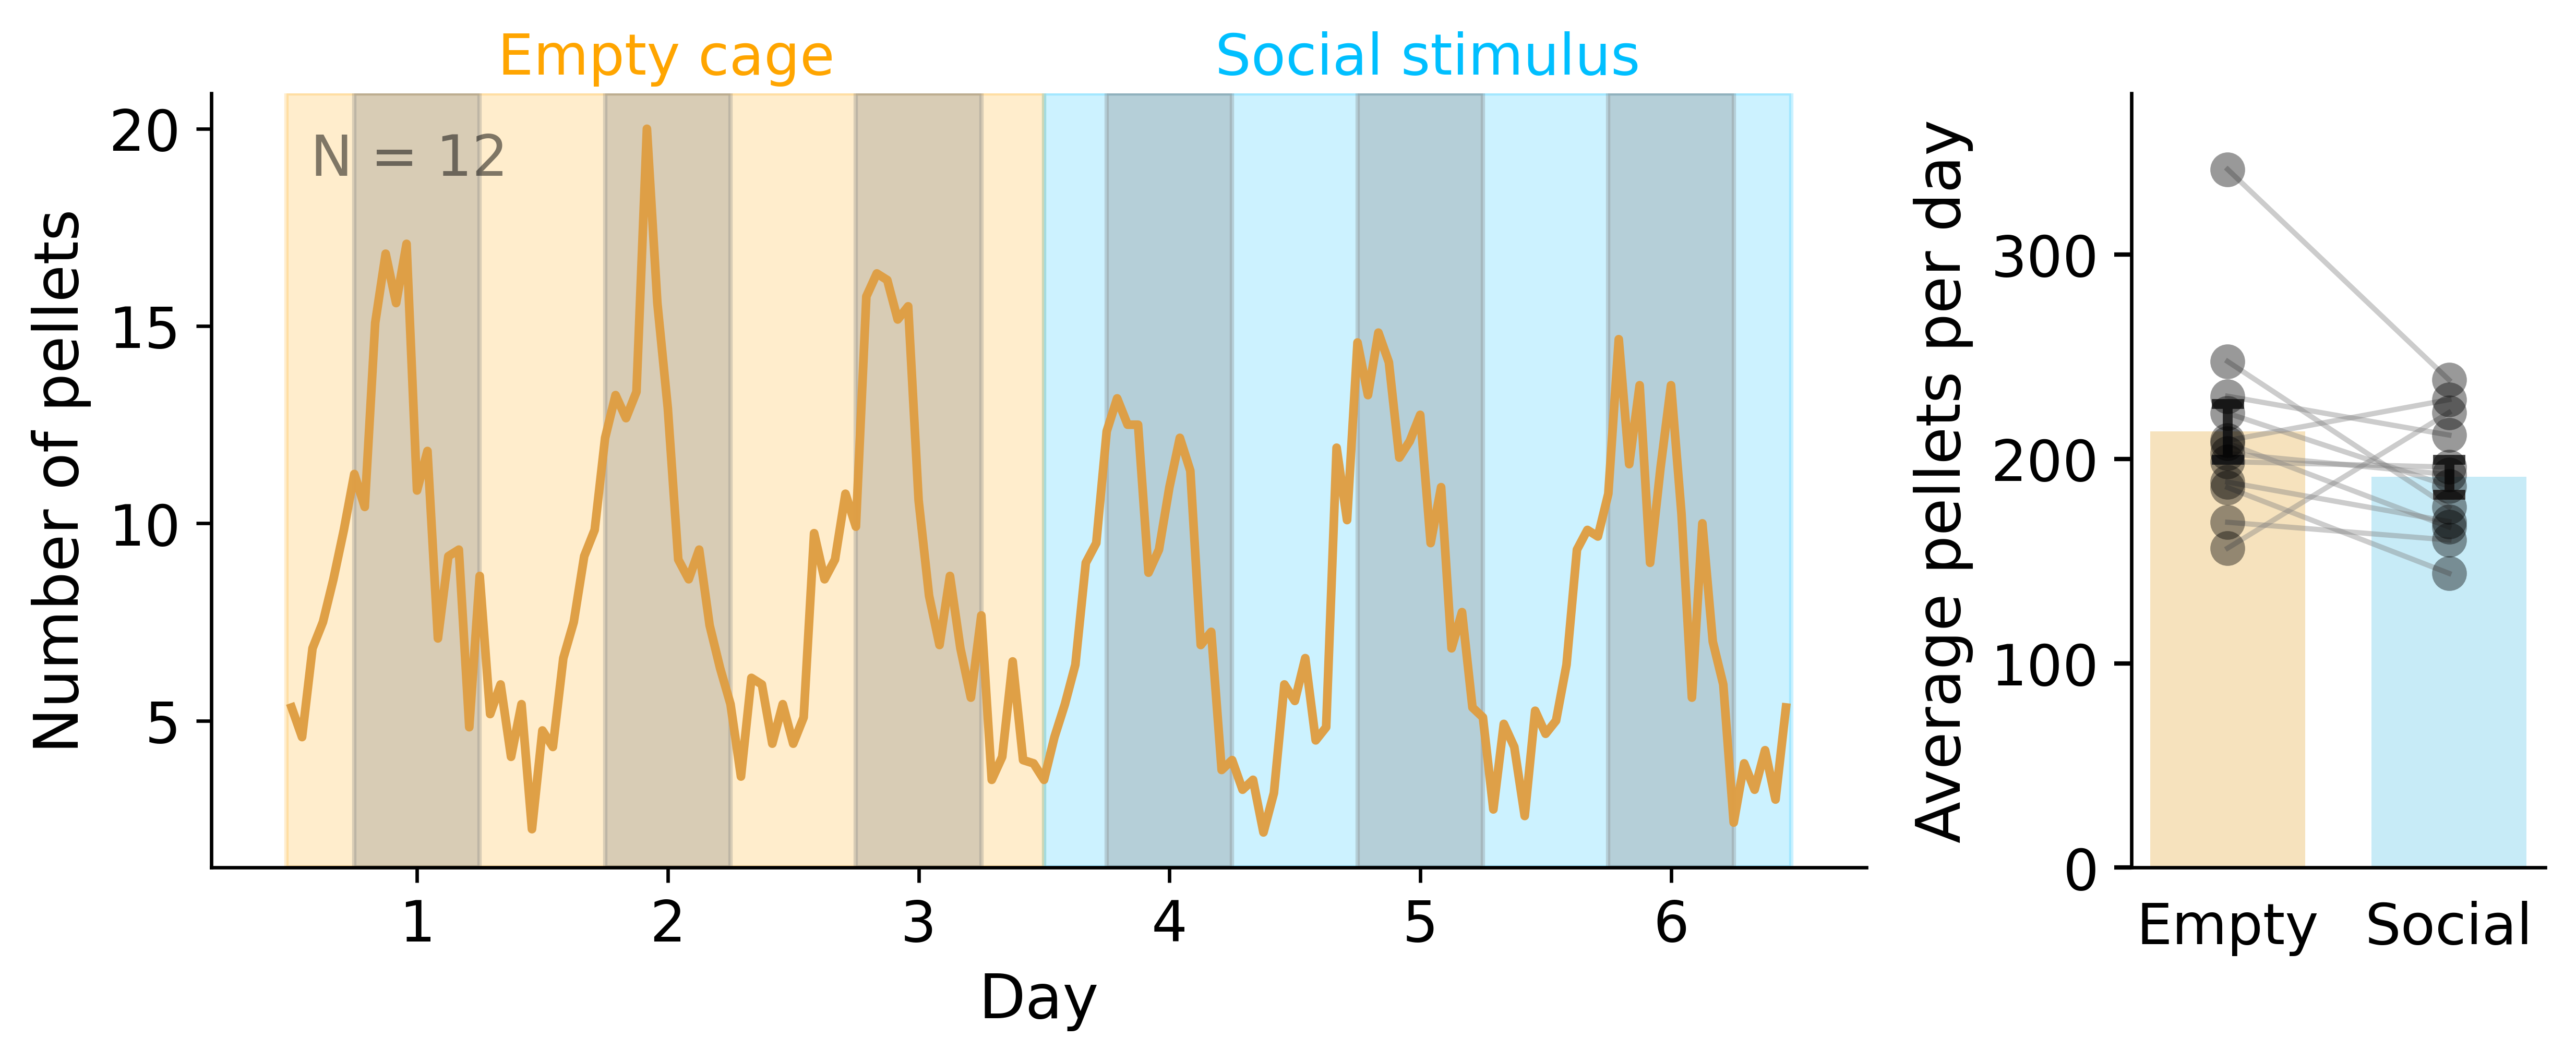

In [6]:
poke_counts = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_FigureS2.csv")

# === Combined Figure ===
fig = plt.figure(figsize=(8.33, 3.5), dpi=600)
gs = fig.add_gridspec(1, 2, width_ratios=[3, 0.75])

# === LEFT PLOT: Clustered Door Opening ===
ax1 = fig.add_subplot(gs[0, 0])
xtick_positions = range(-60, 3 * 24 - 11, 24)
xtick_labels = [1, 2, 3, 4, 5, 6]

ax1.axvspan(-72.5, 0, color='orange', alpha=0.2)
ax1.axvspan(0, 3 * 24-0.5, color='deepskyblue', alpha=0.2)

sns.lineplot(
    data=poke_counts,
    x="hoursfloor",
    y="count",
    color = "#DF9E43F9",
    errorbar=None,
    lw = 2,
    ax=ax1,
)

for start in range(-66, 3 * 24 + 1, 24):
    ax1.axvspan(start, start + 12, color="grey", alpha=0.3)

ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, fontsize=13)
ax1.tick_params(axis="y", labelsize=13)
ax1.set_xlabel("Day", fontsize=14)
ax1.set_ylabel("Number of pellets", fontsize=14)
ax1.yaxis.set_major_locator(MaxNLocator(4, integer=True))
ax1.text(0.275, 1.025, "Empty cage", fontsize=13, color='orange', ha='center', transform=ax1.transAxes)
ax1.text(0.735, 1.025, "Social stimulus", fontsize=13, color='deepskyblue', ha='center', transform=ax1.transAxes)
ax1.legend('', frameon=False)
ax1.text(0.06, 0.95, f'N = {len(poke_counts["device_number"].unique())}',
         transform=ax1.transAxes, fontsize=13, alpha=0.5, va='top', ha='left')
sns.despine(ax=ax1)

# === RIGHT PLOT: Paired Bar Chart ===
ax2 = fig.add_subplot(gs[0, 1])
bar_colors = ['#FFE5B4', '#BFEFFF']
day_poke_counts = poke_counts.groupby(["device_number", 'mode', 'sex', "days", "poke_reward"])['count'].sum().reset_index()
avg_poke_counts = day_poke_counts.groupby(["device_number", 'mode', 'sex', "poke_reward"])['count'].mean().reset_index()

sns.barplot(
    data=avg_poke_counts,
    x='mode',
    y='count',
    errorbar="se",
    capsize=.1,
    palette=bar_colors,
    ax=ax2,
    width=0.7
)

sns.stripplot(
    data=avg_poke_counts,
    x='mode',
    y='count',
    color='black',
    dodge=0.6,
    jitter=False,
    alpha=0.4,
    size=8,
    ax=ax2,
    legend=False
)

# Pivot the data
pivot_df = avg_poke_counts.pivot(index="device_number", columns="mode", values="count").reset_index()

# Draw lines between Empty and Social per device
for _, row in pivot_df.iterrows():
    ax2.plot(["Empty", "Social"], [row["Empty"], row["Social"]], color='gray', alpha=0.4, linewidth=1.2, zorder=1)

from scipy.stats import ttest_rel

# Drop rows with missing values (in case a device is missing either condition)
paired_df = pivot_df.dropna(subset=["Empty", "Social"])

# Perform paired t-test
t_stat, p_val = ttest_rel(paired_df["Empty"], paired_df["Social"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.5f}")

# Use y slightly above max
y_max = paired_df[["Empty", "Social"]].max().max()
add_sig_line(ax2, 0, 1, y_max + 20, p_val)

ax2.set_ylim([0, ax2.get_ylim()[1]+20])
ax2.set_xlabel("")
ax2.set_ylabel("Average pellets per day", fontsize=14)
ax2.tick_params(axis="y", labelsize=13)
ax2.yaxis.set_major_locator(MaxNLocator(4, integer=True))
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:2], labels[:2], fontsize=13, frameon=False)
sns.despine(ax=ax2, left=False)

ax2.tick_params(
    axis='both',
    which='major',
    left=True, top=False, right=False, bottom=False,
    length=4, width=1,
    direction='out',
    labelsize=13
)

# # Save output
plt.tight_layout()